In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.17.4
pandas 1.0.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# https://storage.googleapis.com/tf-datasets/titanic/train.csv
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)  #通过pandas读取文件
eval_df = pd.read_csv(eval_file)

print(type(train_df)) 
print(train_df.head())  #head（）：默认读取前5行
print(eval_df.head())

<class 'pandas.core.frame.DataFrame'>
   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0

In [3]:
y_train = train_df.pop('survived')  #删除survived(),这时标签，不应该在feature中
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [20]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [21]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


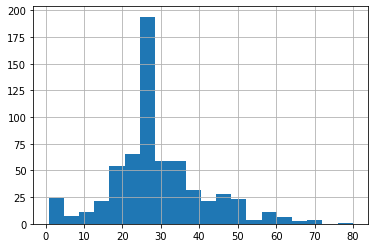

In [22]:
train_df.age.hist(bins = 20)

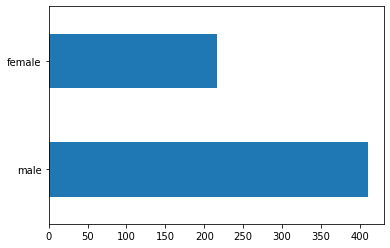

In [23]:
train_df.sex.value_counts().plot(kind = 'barh') # 横的柱状图用'barh',竖的用'barv'

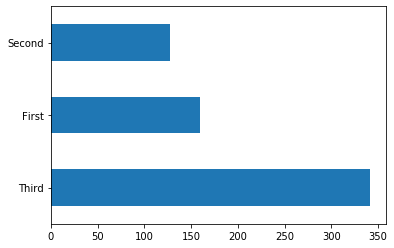

In [24]:
train_df['class'].value_counts().plot(kind = 'barh') # 因为class为关键词，所以要通过键的方式取出'class'的值

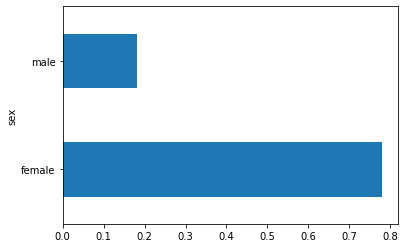

In [25]:
# 统计男性和女性中，分别获救的人数
# 因为train_df中含有survived数据，所以设置轴为1
# groupby(judge):根据judge来分组
# 然后取出survived数据，然后求出均值
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh')


In [26]:
# 构建feature column
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',  #离散特征
                       'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']  #连续特征

feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))

for categorical_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            categorical_column, dtype=tf.float32))
    
'''
unique():
tf.feature_column.indicator_column()：转换为one_hot编码

categorical_column_with_vocabulary_list（）：

tf.feature_column.


numeric_column
'''    

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


'\nunique():\ntf.feature_column.indicator_column()：转换为one_hot编码\n\ncategorical_column_with_vocabulary_list（）：\n\ntf.feature_column.\n\n\nnumeric_column\n'

In [27]:
# 创建dataset
def make_dataset(data_df, label_df, epochs = 10, shuffle = True,
                 batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [28]:
train_dataset = make_dataset(train_df, y_train, batch_size = 5)

In [29]:
import pprint
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=218, shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: id=210, shape=(5,), dtype=float64, numpy=array([36. , 40.5, 19. , 26. , 34.5])>, 'n_siblings_spouses': <tf.Tensor: id=216, shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0], dtype=int32)>, 'parch': <tf.Tensor: id=217, shape=(5,), dtype=int32, numpy=array([0, 2, 0, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: id=215, shape=(5,), dtype=float64, numpy=array([40.125 , 14.5   ,  7.65  , 18.7875,  6.4375])>, 'class': <tf.Tensor: id=212, shape=(5,), dtype=string, numpy=array([b'First', b'Third', b'Third', b'Third', b'Third'], dtype=object)>, 'deck': <tf.Tensor: id=213, shape=(5,), dtype=string, numpy=array([b'A', b'unknown', b'F', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: id=214, shape=(5,), dtype=string, numpy=
array([b'Cherbourg', b'Southampton', b'Southampton', b'Cherbourg',
       b'Cherbourg'], dtype=object)>, 'alone

In [30]:
# keras.layers.DenseFeature
# 可以理解feature_column为对数据进行变换的一组规则，DenseFeature可以将这种规则应用到dataset上的每一个元素
# keras.layers.DenseFeatures(age_column)(x)：将数据x应用到数据集x上
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())  
    # 性别数据原本是字符串（'male', 'female'）,经过feature_column转换后变成了one_hot编码


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[62.]
 [42.]
 [39.]
 [40.]
 [30.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [31]:
# 直接使用feature_column对所有数据进行转换
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[51.    0.    1.    1.    0.    0.    1.    0.    0.    0.    0.    0.
   0.    0.    1.    0.    0.    0.    8.05  0.    1.    0.    0.    0.
   0.    0.    1.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 6.    1.    0.    0.    0.    1.    1.    0.    0.    0.    0.    0.
   0.    0.    1.    0.    0.    0.   33.    0.    1.    0.    0.    0.
   0.    0.    0.    1.    0.    0.    0.    0.    0.    1.  ]
 [20.    0.    1.    1.    0.    0.    1.    0.    0.    0.    0.    0.
   0.    0.    1.    0

In [33]:
# 构建模型  
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(lr=0.01),
              metrics = ['accuracy'])


In [34]:
#常规fit

train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs = 1, shuffle = False)
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 20,
                    validation_steps = 8,
                    epochs = 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 20 steps, validate for 8 steps
Epoch 1/100
20/20 [==============================] - 2s 111ms/step - loss: 2.4919 - accuracy: 0.5922 - val_loss: 0.6895 - val_accuracy: 0.6914
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 0.7142 - accuracy: 0.6687 - val_loss: 0.6077 - val_accuracy: 0.6992
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 0.6818 - accuracy: 0.6609 - val_loss: 0.6329 - val_accuracy: 0.6953
Epoch 4/100
20/20 [=====================

20/20 [==============================] - 0s 19ms/step - loss: 0.5346 - accuracy: 0.7469 - val_loss: 0.5500 - val_accuracy: 0.7070
Epoch 54/100
20/20 [==============================] - 0s 15ms/step - loss: 0.5348 - accuracy: 0.7172 - val_loss: 0.6273 - val_accuracy: 0.6953
Epoch 55/100
20/20 [==============================] - 0s 12ms/step - loss: 0.5437 - accuracy: 0.7391 - val_loss: 0.5195 - val_accuracy: 0.7070
Epoch 56/100
20/20 [==============================] - 0s 11ms/step - loss: 0.5384 - accuracy: 0.7359 - val_loss: 0.5058 - val_accuracy: 0.7812
Epoch 57/100
20/20 [==============================] - 0s 22ms/step - loss: 0.5212 - accuracy: 0.7422 - val_loss: 0.8932 - val_accuracy: 0.4961
Epoch 58/100
20/20 [==============================] - 0s 17ms/step - loss: 0.5348 - accuracy: 0.7547 - val_loss: 0.5252 - val_accuracy: 0.7305
Epoch 59/100
20/20 [==============================] - 0s 16ms/step - loss: 0.5243 - accuracy: 0.7625 - val_loss: 0.5262 - val_accuracy: 0.7305
Epoch 60/100

ValueError: Empty training data.

In [35]:
# 将模型转化为estimator后训练
estimator = keras.estimator.model_to_estimator(model)
# 1. function
# 2. return a. (features, labels) b. dataset -> (feature, label)
estimator.train(input_fn = lambda : make_dataset(  # 通过lambda函数对make_dataset()进行封装，
    train_df, y_train, epochs=100))

'''
estimator.train(input_fn = func)
参数是一个函数，这个函数不能有参数；
返回值需要是一个元组（列表也可以？），其格式为（feature,label）或者数据集（数据集内的元素也要是feature,label）格式）


'''

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3puct7vv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f40d9e56f10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_e

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.

In [1]:

import os
from tensorflow.python.client import device_lib
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "99"
 
if __name__ == "__main__":
    print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9867395276961898360
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17014634552032383916
physical_device_desc: "device: XLA_CPU device"
]
